# Classification d'emails

Ce projet a été réalisé en binôme par Suruthy SEKAR et Mathilde DA CRUZ.

Le but du projet est de parvenir à prédire pour un email donné s'il s'agit d'un courriel ou d'un pourriel (nommés *ham* et *spam* respectivement dans nos variables). Pour ce faire, nous disposons de données brutes (notre *dataset*) d'emails déjà classifiés comme données de départ.

Nous verrons que dans un premier temps il a été question de parvenir à lire les données et les exploiter pour pouvoir y appliquer des algorithmes par la suite.

Nous avons utilisé la programmation orientée objet en séparant le projet en plusieurs classes que nous expliquerons.

### Table des matières

* [Exploration des données](#expl)
    * [Proportion ham/spam](#prop)
    * [Les différents types](#types)
* [Traitement des données](#Processed_data)
* [Prédiction sur les données](#analyse)
* [Naïve Bayes](#naive_bayes)
* [Régression logistique](#regression_logistique)
* [SVM](#svm)
* [Arbres](#arbres)
* [Récapitulatif des résultats](#recap)

In [1]:
import os
import email
import email.policy
import math
from collections import Counter
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
import sys
from email.iterators import _structure
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import re
from IPython.display import Image
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
import pyprind

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

import random

# Exploration des données (classe Raw_data) <a name="expl"></a>

La première chose dont il est question est de trier les données en fonction de s'ils sont courriels ou des pourriels en détectant la présence du mot "ham" ou "spam" dans le titre du dossier. Ensuite, nous traiterons nos données brutes avec un analyseur syntaxique ("BytesParser"). Pour ce faire, nous créeons une class Raw_data qui représentera nos données brutes, auxquelles nous pourrons appliquer des méthodes.

In [35]:
class Raw_data:
    
    folder_names = []
    ham = None
    spam = None
    
    def __init__(self, folder):
        
        ''' 
        Ceci est le constructeur de la classe Raw_data qui représente le preprocessing, avec les données brutes au départ.
        
        Parametres 
        -----
        folder : string
            l'adresse du dossier contenant tout le dataset 
            (avec donc des sous dossiers contenant séparément les hams et les spams)
        '''
        
        self.folder = folder
        self.folder_names = []
        
        
    def expl(self):
        
        '''Cette fonction permet de regrouper tous les dossiers contenant des spams ensemble et ceux contenant des hams
        ensemble. Elle permet également de compter le nombre de mails et d'afficher la proportion ham/spam.
        Elle renvoie un message d'erreur si un dossier ne contient ni le mot "ham" ni le mot "spam" et qu'il est donc
        impossible à classifier.'''
        
        spam = 0
        ham = 0
        spam_n = []
        ham_n = []
        dataset = os.listdir(self.folder)

        for directory in dataset:
            if directory.find('spam') != -1:
                spam += len(os.listdir('../dataset/' + directory))
                spam_n.append(directory)
            elif directory.find('ham') != -1:
                ham += len(os.listdir('../dataset/' + directory))
                ham_n.append(directory)
            else:
                print('Erreur dans le dataset')
        print('Number of ham : ', ham)
        print('Number of spam :', spam)
        print('Il y a', ham+spam, 'mails dans notre base de données dont', math.floor((spam/(spam+ham)*100)), '% de spams')
        self.folder_names = [ham_n, spam_n]
    
    
    def load_email(self, emails, ham_or_spam):  
        
        '''load_email permet d'analyser les emails syntaxiquement afin de séparer les différentes parties au sein
        de celui-ci (destinataire, date, etc.). Elle remplit les attributs ham et spam de la classe avec des emails bruts.
        
        parametres 
        -----
        emails : list 
                Represente la liste des dossiers qui contiennent les emails à loader
                
        ham_or_spam : int
                Si 1 est donné, les emails seront classés spam.
                Pour un autre nombre ils sont classés ham.
        
        '''
        
        k = 0
        res_email = []
        for i in emails:
            for j in os.listdir(self.folder + i):
                input = self.folder + i + '/' + j
                with open(os.path.join(input), 'rb') as file :
                    em = email.parser.BytesParser(policy=email.policy.default).parse(file)
                res_email.append(em)    
        if (ham_or_spam):
            self.spam = res_email
        else:
            self.ham = res_email
            
    def show_types(self) :
        
        '''Cette fonction parcourt l'ensemble des emails de notre base de données et détermine le type. 
        Ces données sont ensuite stockées dans un objet de type Counter avant d'être affichées
        '''
        
        if (self.ham == None or self.spam == None):
            print('Veuillez parser un dataset')
            return
            
        def type_mess(mails) :
            t = []
            for i in range (len(mails)) :
                t.append(mails[i].get_content_type())
            return t 
    
        fig1 = plt.figure(figsize=(14,4))
        plt.bar(Counter(type_mess(self.spam)).keys(), Counter(type_mess(self.spam)).values(), width=.5)
        fig1.suptitle('Pourriel', fontsize=16)

        fig2 = plt.figure(figsize=(14,4))
        plt.bar(Counter(type_mess(self.ham)).keys(), Counter(type_mess(self.ham)).values(), width=.5)
        fig2.suptitle('Courriel', fontsize=16)

        plt.show()

Commençons par nous représenter le contenu des dossiers. <a name="prop"></a>

In [36]:
raw_data = Raw_data('../dataset/')
raw_data.expl()

Number of ham :  4150
Number of spam : 1896
Il y a 6046 mails dans notre base de données dont 31 % de spams


Maintenant que nous avons classifiés toutes nos données de départ, nous allons maintenant les faire analyser syntaxiquement par "BytesParser" de la classe email qui se chargera de transformer nos données brutes en un objet de la classe email (sous-classe de dictionnaire) et permet un accès facile aux parties du mail auxquelles on désire accéder.

In [4]:
%time raw_data.load_email(raw_data.folder_names[0], 0)
%time raw_data.load_email(raw_data.folder_names[1], 1)

Wall time: 5.7 s
Wall time: 5.84 s


En ouvrant certains emails nous nous apercevons qu'ils n'ont pas tous le meme type, ni le même encodage. Pour pouvoir tous les convertir, nous avons d'abord besoin d'énumérer et visualiser la proportion des différents types présents.
<a name="types"></a>

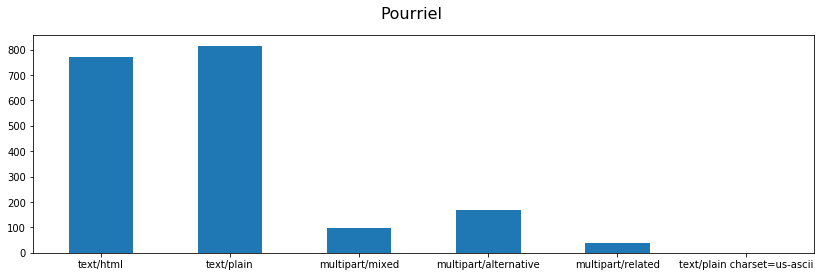

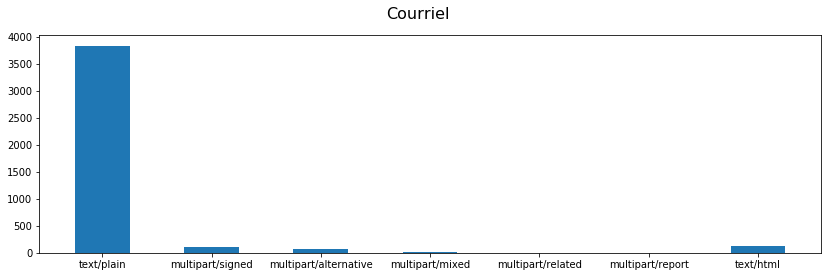

In [5]:
raw_data.show_types()

Il y a ici plusieurs types qui se dégagent :
- le type text/plain : le type désiré car le plus simple à lire et à traiter ensuite
- le type text/html
- le type multipart : qui contient plusieurs types en lui-même ; text/plain, text/html ou les deux. Il s'agit notamment des emails avec photos.

# Traitement des données <a name="Processed_data"></a>

Un objet de cette classe est représentée par un DataFrame de la librairie pandas. Ce dataframe, nommé *corpus*, contient les données déjà analysées par un parser à l'étape précédente, dont nous avons sélectionné seulement certaines catégories.

A partir de cet objet de la classe TF IDF, il sera ensuite question d'appliquer des méthodes qui permettront de générer un bag of words ou encore les TF IDF.

In [6]:
class Processed_data:
    
    bow = None
    tfidf = None
    
    def __init__(self, ham, spam, list_headers):
        
        '''Le constructeur de la classe construit le dataframe associé aux données analysées précédemment.
         Notons que le paramètre list_headers permet de sélectionner la liste des paramètres que nous souhaitons garder.
         List_headers devra obligatoirement commencer par 'Label' (0 pour ham, 1 pour spam) et se terminer par 'Content'
        
        Parametres
        -----
        ham : list
            Liste des adresses des ham en format brut
        
        spam : list 
            Liste des adresses des spam en format brut
        
        list_headers : list
            Liste des colonnes désirées pour la construction du dataframe.
        
        '''
        if(ham == None or spam == None):
            print("Veuillez parser les emails")
            return
        if list_headers[0] != 'Label' or list_headers[-1] != 'Content' :
            print("la liste des headers doit commencer par le label et se terminer par le contenu")
            return
        x = self.to_dataframe(spam, 1, list_headers)
        y = self.to_dataframe(ham, 0, list_headers)
        self.corpus = (pd.concat([y, x])).dropna()

    def to_dataframe(self, emails, label, list_headers):
        
        '''Cette fonction est le coeur de la création d'un objet de cette classe : elle est appelée par
        le constructeur et crée un dataframe dont les colonnes sont celles indiquées lors de la construction de l'objet
        
        Parametres :
        -----
        emails : list
            Liste des adresses des emails en format brut
        
        label : int
            Label qu'on veut donner aux emails. Dans notre cas, 1 est pour spam et 0 pour ham.
        
        list_headers : list
            Liste des colonnes désirées pour la construction du dataframe.
        
        '''
        
        list_values = []
        for email in pyprind.prog_percent(emails):
            tmp = []
            try:
                tmp.append(label)
                for i in range(1, len(list_headers)-1):
                    tmp.append(email[list_headers[i]])
                tmp.append(self.email_to_plain(email)) #Content
                list_values.append(tmp)
            except TypeError:
                tmp.append(None)
        df = pd.DataFrame(list_values, columns=list_headers)
        return df
   
    
    def email_to_plain(self, email):
        
        '''Cette fonction convertit le contenu d'un email en 'plain/text' selon qu'il s'agisse d'un type multipart ou html
        
        Parametres 
        -----
        email : email.message.EmailMessage
            l'email dont le contenu sera converti
        
        '''
        res =''
        for part in email.walk():
            if(part.get_content_type() == 'text/plain'):
                try :
                    res = part.get_content()
                except:
                    res = part.get_payload() #si encodage non géré par get_content()
                return res
            if(part.get_content_type() == 'text/html'):
                res = self.html_to_plain(part)
                return res

    def html_to_plain(self, email):
        
        '''Fonction spécifique qui convertit le type html/text en plain/text
        
        Parametres 
        ----- 
        email : email.message.EmailMessage
           l'email dont le contenu sera converti
        
        '''
        try:
            mail = BeautifulSoup(email.get_content(), 'html.parser')
            return mail.text.replace('\n\n','')
        except:
            return None

        
        
    def tokenize(self, content, stopwords = None):
        
        '''Cette fonction convertit une chaine de caractères en une liste de mots individuels dont la ponctuation a été retirée.
        Seuls les mots de plus de 2 lettres sont conservés.
        
        Parametres 
        -----
        content : string
            le message a tokenizer
        
        stopwords : list
            None par default. Une liste de mot
        
        
        '''
        reg = re.compile('[a-z][a-z][a-z]+')
        reg = reg.findall(content.lower())
        tag_map = defaultdict(lambda : wn.NOUN)
        tag_map['J'] = wn.ADJ
        tag_map['V'] = wn.VERB
        tag_map['R'] = wn.ADV
        pos_tagged = pos_tag(reg)
        wnl = WordNetLemmatizer()
        res = []
        #if stopwords :
        #    res = [i for i in reg if i not in stopwords]
        for word, lemma in pos_tagged:
            if stopwords: 
                if word not in stopwords:
                    res.append(wnl.lemmatize(word, tag_map[lemma[0]])) #on regarde la première lettre
        return res
    
    def bag_of_words(self, stop_w = None, column = 'Content'):
        
        '''On construit ici un dataframe dont une ligne représente un email, les colonnes représentent l'ensemble des mots
        du dictionnaire. Une cellule représente le nombre d'apparition d'un certain mot dans un certain email
         
         Parametres
         -----
         stop_w : list
             liste de stopwords
         
         column : str ('Content' ou 'Subject')
             indique si le bag of word doit etre fait sur la colonne du contenu ou bien celle de l'objet du mail
             
         '''
        if column not in ['Content','Subject'] :
            print ('Veuillez indiquer \'Content\' ou \'Subject\' pour la colonne choisie.')
            return
        dico = []
        for i in pyprind.prog_percent(range(self.corpus.shape[0])):
            dico.append(Counter(self.tokenize(self.corpus.iloc[i][column], stop_w)))
        self.bow = pd.DataFrame(dico).fillna(0)
    
    def compute_tf(self, word, document) :
        
        '''Cette methode calcule le term frequency pour un mot par rapport
        au document dans lequel il se trouve
        
        Parametres
        -----
        word : int 
            indice du mot
        
        document : int
            indice du document
        
        '''
        return self.bow.iloc[document][word]/self.bow.iloc[document].sum()
    
    def compute_idf(self, word) :
        '''Cette methode calcule le inverse document frequency pour un mot par rapport à tout le corpus
        
        Parametres
        ----
        word : int
        indice du mot
        
        '''
        n = self.bow.shape[0]
        return math.log(n/np.count_nonzero(self.bow.iloc[:, word]))
    
    def build_tfidf2(self) :
        '''Cette methode calcule le tf-idf d'un mot par rapport à un document. 
        C'est à dire l'importance du mot dans ce document par rapport à l'ensemble du corpus.
        
        '''
        x = self.bow.shape
        df = self.bow.copy()
        for j in range(x[1]): #colonnes
            idf = self.compute_idf(j) #on ne le calcule qu'une fois par colonne
            for i in range(x[0]): #lignes
                if i != 0 :
                    tf = self.compute_tf(j, i)
                    df.iloc[i][j] = tf * idf
        self.tfidf = df
        
    def build_tfidf(self) :
        if self.bow is None:
            self.bag_of_words(self.stop_w)
        f = TfidfTransformer(use_idf = True, norm='l2', smooth_idf = True)
        self.tfidf = f.fit_transform(self.bow).toarray()
        

Bien que cette classe ne sera jamais instanciée directement (puisqu'elle sera seulement appelée par une classe héritée de celle-ci, nous le verrons plus bas), testons tout de même les méthodes que nous avons écrites afin d'avoir une idée claire de ce que nous sommes en train de faire.

In [7]:
list_headers = ['Label', 'From', 'Date', 'Subject', 'Content']
p_data = Processed_data(raw_data.ham, raw_data.spam, list_headers)

[100 %] Time elapsed: 00:00:11 | ETA: 00:00:00
Total time elapsed: 00:00:11
[100 %] Time elapsed: 00:00:13 | ETA: 00:00:00
Total time elapsed: 00:00:13


Regardons de plus près la façon dont le corpus a été stocké dans le dataframe pour nous assurer que notre fonction corresponde à nos attentes.

In [8]:
p_data.corpus.head()

,Label,From,Date,Subject,Content
0,0,Robert Elz <kre@munnari.OZ.AU>,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
1,0,Steve Burt <Steve_Burt@cursor-system.com>,"Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre..."
2,0,Tim Chapman <timc@2ubh.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...
3,0,Monty Solomon <monty@roscom.com>,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...
4,0,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi..."


Bien que cela ne soit pas absolument nécessaire, nous pouvons créer le dataframe qui représente le bag of words du corpus donné. Affichons également les premières lignes de celui-ci, cela nous permettra de vérifier que la conversion en plain text puis la tokenization a bien fonctionné.

In [9]:
%time p_data.bag_of_words(stopwords.words('english'), 'Content')

[100 %] Time elapsed: 00:02:19 | ETA: 00:00:00
Total time elapsed: 00:02:19


Wall time: 3min 42s


In [10]:
p_data.bow.head()

,date,wed,aug,chris,garrigues,cwg,deepeddy,com,message,tmda,...,aggrandize,composure,soothes,refreshes,hairricane,pkg,drops,adsub,kamela,wilsonkamela
0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prédictions sur les données <a name="analyse"></a>

La classe Prédicteur, ci-dessous, est héritée de Processed_data. Elle hérite donc de l'ensemble de ses attributs ainsi que ses méthodes. En effet, 

In [11]:
class Predicteur(Processed_data):
    content = dict()
    subject = dict()
    
    def __init__(self,ham, spam, list_headers, stop_w = [], column = 'Content'):
        '''Ceci est le constructeur de la classe Predicteur qui est héritée de la classe Processed_data'''
        super().__init__(ham, spam, list_headers)
        self.stop_w = stop_w
        self.column = column
        if self.bow is None:
            self.bag_of_words(self.stop_w, self.column)
        
    def naive_bayes(self):
        X = self.bow
        y = self.corpus['Label']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        classifier = GaussianNB()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        T = self.show_results(X_test, y_test, y_pred)
        if (self.column == 'Content'):
            self.content.update({'Naïve Bayes': T})
        else:
            self.subject.update({'Naïve Bayes' : T})
    
    def regression_logistique(self, methode):
        '''paramètre 
        -----
        methode : string ('tfidf' ou 'bow')
        represente la méthode utilisée, c'est à dire sur quoi se base l'algorihtme
        Soit sur la matrice avec tfidf soir sur bag of words.
        '''
        if methode == 'tfidf' :
            if self.tfidf is None:
                self.build_tfidf()
            X = self.tfidf
        elif methode == 'bow' :
            X = self.bow
        else :
            print ('Veuillez indiquer une methode qui soit tfidf ou bow')
            return
        y = self.corpus['Label']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        classifier = LogisticRegression(solver='liblinear')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        T = self.show_results(X_test, y_test, y_pred)
        if (self.column == 'Content'):
            if(methode == 'tfidf'):
                self.content.update({'Régression logistique (TFIDF)': T})
            else:
                self.content.update({'Régression logistique (BOW)': T})
        else:
            if(methode == 'tfidf'):
                self.subject.update({'Régression logistique (TFIDF)': T})
            else:
                self.subject.update({'Régression logistique (BOW)': T})
            
    
    def show_results(self, X_test, y_test, y_pred):
        '''
        paramètres
        -----
        X_test : DataFrame
        Les données sur lesquelles l'algorithme s''est entrainé
        y_test : Dataframe
        Les labels des données sur lesquelles l'algo s'est entrainé
        y_pred : Dataframe
        Les prédictions faites par l'algo
        
        '''
        print("Pourcentage d'emails bien classés : " + "{:.0%}".format(accuracy_score(y_test, y_pred)))
        print("Nombre d'emails mal classés sur un total de %d emails : %d"% (X_test.shape[0], (y_test != y_pred).sum()))
        y_test = y_test.values
        fp = 0
        fn = 0
        for i in range(len(y_test)):
            if y_test[i] == 1:
                if y_pred[i] == 0:
                    fn += 1
            elif y_test[i] == 0:
                if y_pred[i] == 1:
                    fp += 1
        print('Nombre de faux positifs : %d'% (fp))
        print('Nombre de faux négatifs : %d'% (fn))
        labels = 'Faux positifs', 'Faux négatifs'
        sizes = [fp, fn]
        explode = (0, 0.1) 
        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        ax1.axis('equal')
        plt.legend()
        plt.show()
        return (accuracy_score(y_test, y_pred), fp, fn)
        
    def compare_algorithms(self):
        X = self.bow
        y = self.corpus['Label']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        classifier = LogisticRegression(solver='liblinear')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print("Résultats pour la régression logistique : ")
        self.show_results(X_test, y_test, y_pred)
        classifier = GaussianNB()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print("Résultats pour naïve Bayes : ")
        self.show_results(X_test, y_test, y_pred)
        
    def pca(self):
        x = StandardScaler().fit_transform(self.bow)
        y = self.corpus['Label']
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
        finalDf = principalDf.assign(target=self.corpus["Label"].values)
        finalDf['target'] = finalDf['target'].map(lambda a: 'ham' if a == 0 else 'spam' )
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title('2 component PCA', fontsize = 20)
        targets = ['ham', 'spam']
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = finalDf['target'] == target
            ax.scatter(finalDf.loc[indicesToKeep, 'component 1'], finalDf.loc[indicesToKeep, 'component 2'], c = color, s = 50)
        ax.legend(targets)
        ax.grid()
        
    def svm(self):
        X = self.bow
        y = self.corpus['Label']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        param = {'C': [0.1, .5, 1, 1.5, 2, 5, 10, 50], 'kernel': ['linear', 'rbf']} 
        svc = svm.SVC(gamma = 'auto')
        clf = GridSearchCV(svc, param, cv=3)
        clf.fit(X_train, y_train)
        p = clf.best_params_
        print('Meilleur set de paramètres : %s'% p)
        svc = svm.SVC(C = p['C'], kernel=p['kernel'])
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        T = self.show_results(X_test, y_test, y_pred)
        if (self.column == 'Content'):
            self.content.update({'svm': T})
        else:
            self.subject.update({'svm': T})
        
    def d_tree(self, impurity, max_depth) :
        '''
        paramètres
        -----
        impurity : string ('gini' ou 'entropy')
        méthode utilisée pour calculer l'impureté d'un noeud
        max_depth : int
        Profondeur maximale d'un arbre
        
        '''
        if self.bow is None:
            self.bag_of_words(self.stop_w)
        X = self.bow
        y = self.corpus['Label']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = DecisionTreeClassifier(criterion = impurity, max_depth = max_depth, random_state = 1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        T = self.show_results(X_test, y_test, y_pred)
        plt.figure(figsize=(15,15))
        tree.plot_tree(clf, feature_names = self.bow.columns, fontsize=10)
        plt.show()
        if (self.column == 'Content'):
            if(impurity == 'gini'):
                self.content.update({'Arbre de décision (Gini)': T})
            else:
                self.content.update({'Arbre de décision (Entropy)': T})
        else:
            if(impurity == 'entropy'):
                self.subject.update({'Arbre de décision (Gini)': T})
            else:
                self.subject.update({'Arbre de décision (Entropy)': T})
        
    def random_forest(self) :
        if self.bow is None:
            self.bag_of_words(self.stop_w)
        X = self.bow
        y = self.corpus['Label']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        param = {'criterion': ['gini', 'entropy'],'max_depth' : [4,6,8,10],
                 'n_estimators' : [50, 100, 150, 200]}
        rfc_grid =RandomForestClassifier(random_state=1)
        rfc_grid = GridSearchCV(rfc_grid, param, cv = 5)
        rfc_grid.fit(X_train, y_train)
        p = rfc_grid.best_params_
        print('Meilleur set de paramètres : %s'% p)
        rfc = RandomForestClassifier(criterion = p['criterion'], max_depth = p['max_depth'], n_estimators = p['n_estimators'],
                                     max_features = 'auto', random_state = 1 )
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        T = self.show_results(X_test, y_test, y_pred)
        plt.figure(figsize=(15,15))
        #tree.plot_tree(rfc.estimators_[0], feature_names=self.bow.columns, fontsize=10)
        #plt.show()
        if (self.column == 'Content'):
            self.content.update({'Random Forest': T})
        else:
            self.subject.update({'Random Forest': T})
            
            
        


Nous allons maintenant utiliser nos prédicteurs. 

Nous souhaitons les tester sur la colonne Content (contenu du mail) mais aussi sur la colonne subject (objet du mail). En effet l'objet contient beaucoup moins de mots, et les calculs sont donc bien plus rapides. Nous souhaitions donc savoir s'il etait possible d'utiliser cette méthode beaucoup plus économique.

Nous commençons donc par créer différents objets de la classe prédicteur.

predicteur_c sera utilisé pour des prédictions qui utilisent le contenu.

predicteur_s utilisera l'objet.

Enfin, nous avons également créé predicteur_small qui utilisera le contenu, mais seulement sur 10% de nos données. En effet, l'algorithme du SVM recherche les meilleurs paramètres pour le SVM, ce qui prend plus de temps, et nous n'avons pas pu faire tourner l'algorithme sur la totalité de nos données.

In [12]:
list_headers = ['Label', 'From', 'Date', 'Subject', 'Content']
%time predicteur_c = Predicteur(raw_data.ham, raw_data.spam, list_headers, stopwords.words('english'))
%time predicteur_s = Predicteur(raw_data.ham, raw_data.spam, list_headers, stopwords.words('english'), 'Subject')
%time predicteur_small = Predicteur(random.sample(raw_data.ham,415), random.sample(raw_data.spam,190), list_headers, stopwords.words('english'))

[100 %] Time elapsed: 00:00:29 | ETA: 00:00:00
Total time elapsed: 00:00:29
[100 %] Time elapsed: 00:00:18 | ETA: 00:00:00
Total time elapsed: 00:00:18
[100 %] Time elapsed: 00:02:19 | ETA: 00:00:00
Total time elapsed: 00:02:19


Wall time: 4min 7s


[100 %] Time elapsed: 00:00:21 | ETA: 00:00:00
Total time elapsed: 00:00:21
[100 %] Time elapsed: 00:00:19 | ETA: 00:00:00
Total time elapsed: 00:00:19
[100 %] Time elapsed: 00:00:22 | ETA: 00:00:00
Total time elapsed: 00:00:22


Wall time: 1min 7s


[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:01 | ETA: 00:00:00
Total time elapsed: 00:00:01
[100 %] Time elapsed: 00:00:08 | ETA: 00:00:00
Total time elapsed: 00:00:08


Wall time: 12.1 s


In [13]:
predicteur_c.bow.columns

Index(['date', 'wed', 'aug', 'chris', 'garrigues', 'cwg', 'deepeddy', 'com',
       'message', 'tmda',
       ...
       'aggrandize', 'composure', 'soothes', 'refreshes', 'hairricane', 'pkg',
       'drops', 'adsub', 'kamela', 'wilsonkamela'],
      dtype='object', length=60404)

In [14]:
predicteur_s.bow.columns

Index(['new', 'sequence', 'window', 'zzzzteana', 'alexander', 'moscow',
       'bomber', 'irr', 'klez', 'virus',
       ...
       'vary', 'aufd', 'iuju', 'mbvod', 'sense', 'prefer', 'smoker',
       'cannabis', 'wilson', 'kamela'],
      dtype='object', length=4963)

## PCA

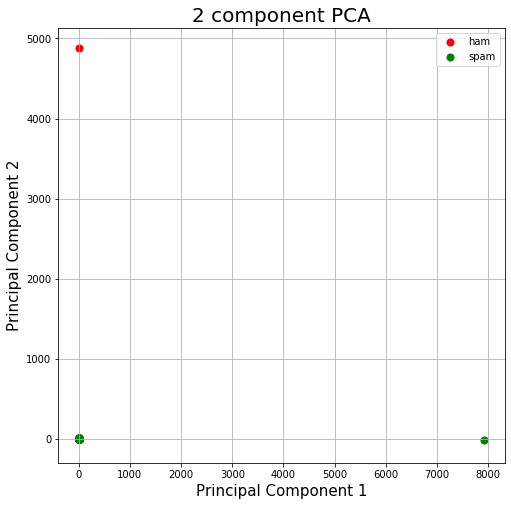

In [15]:
predicteur_c.pca()

## Naïve Bayes <a name="naive_bayes"></a>

### Naïve Bayes sur le contenu

Pourcentage d'emails bien classés : 94%
Nombre d'emails mal classés sur un total de 1505 emails : 84
Nombre de faux positifs : 9
Nombre de faux négatifs : 75


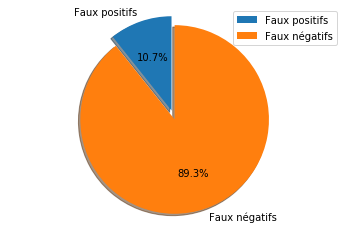

Wall time: 11.9 s


In [16]:
%time predicteur_c.naive_bayes()

### Naïve Bayes sur l'objet

Pourcentage d'emails bien classés : 88%
Nombre d'emails mal classés sur un total de 1505 emails : 178
Nombre de faux positifs : 131
Nombre de faux négatifs : 47


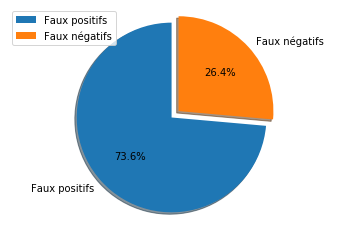

Wall time: 1.14 s


In [17]:
%time predicteur_s.naive_bayes()

## Regression Logistique  <a name="regression_logistique"></a>

### Regression logistique sur le contenu avec tfidf

Pourcentage d'emails bien classés : 97%
Nombre d'emails mal classés sur un total de 1505 emails : 52
Nombre de faux positifs : 7
Nombre de faux négatifs : 45


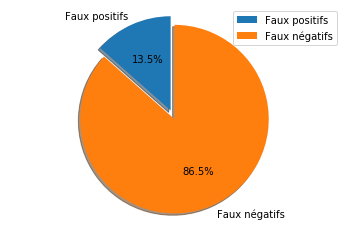

Wall time: 20.1 s


In [18]:
%time predicteur_c.regression_logistique('tfidf')

### Regression logistique sur le contenu avec bag of words

Pourcentage d'emails bien classés : 98%
Nombre d'emails mal classés sur un total de 1505 emails : 24
Nombre de faux positifs : 12
Nombre de faux négatifs : 12


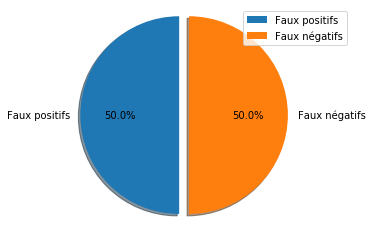

Wall time: 9.13 s


In [19]:
%time predicteur_c.regression_logistique('bow')

### Regression logistique sur l'objet avec tfidf

Pourcentage d'emails bien classés : 87%
Nombre d'emails mal classés sur un total de 1505 emails : 203
Nombre de faux positifs : 14
Nombre de faux négatifs : 189


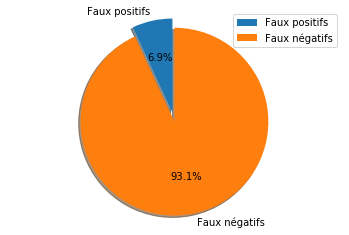

Wall time: 1.64 s


In [20]:
%time predicteur_s.regression_logistique('tfidf')

### Regression logistique sur l'objet avec bag of words

Pourcentage d'emails bien classés : 90%
Nombre d'emails mal classés sur un total de 1505 emails : 152
Nombre de faux positifs : 45
Nombre de faux négatifs : 107


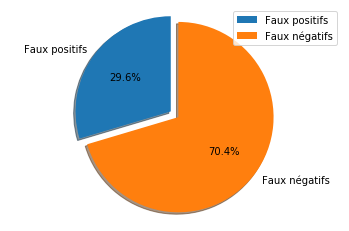

Wall time: 512 ms


In [21]:
%time predicteur_s.regression_logistique('bow')

## SVM  <a name="svm"></a>

### SVM sur le contenu

Meilleur set de paramètres : {'C': 0.1, 'kernel': 'linear'}
Pourcentage d'emails bien classés : 94%
Nombre d'emails mal classés sur un total de 151 emails : 9
Nombre de faux positifs : 3
Nombre de faux négatifs : 6


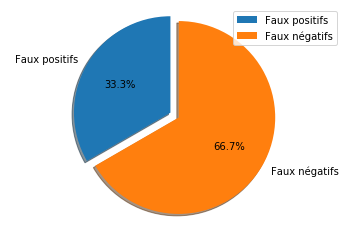

Wall time: 1min 10s


In [22]:
%time predicteur_small.svm()

### SVM sur l'objet

Meilleur set de paramètres : {'C': 0.5, 'kernel': 'linear'}
Pourcentage d'emails bien classés : 89%
Nombre d'emails mal classés sur un total de 1505 emails : 159
Nombre de faux positifs : 54
Nombre de faux négatifs : 105


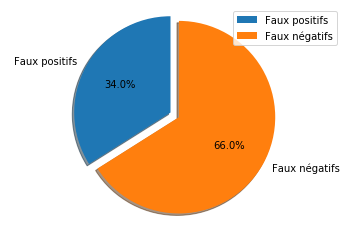

Wall time: 41min 16s


In [23]:
%time predicteur_s.svm()

## Arbres  <a name="arbres"></a>

### Arbres de décison sur le contenu avec Gini

Pourcentage d'emails bien classés : 87%
Nombre d'emails mal classés sur un total de 1505 emails : 203
Nombre de faux positifs : 49
Nombre de faux négatifs : 154


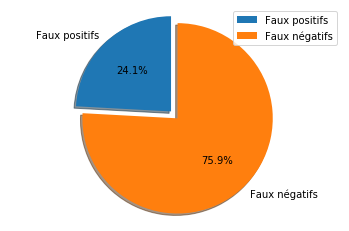

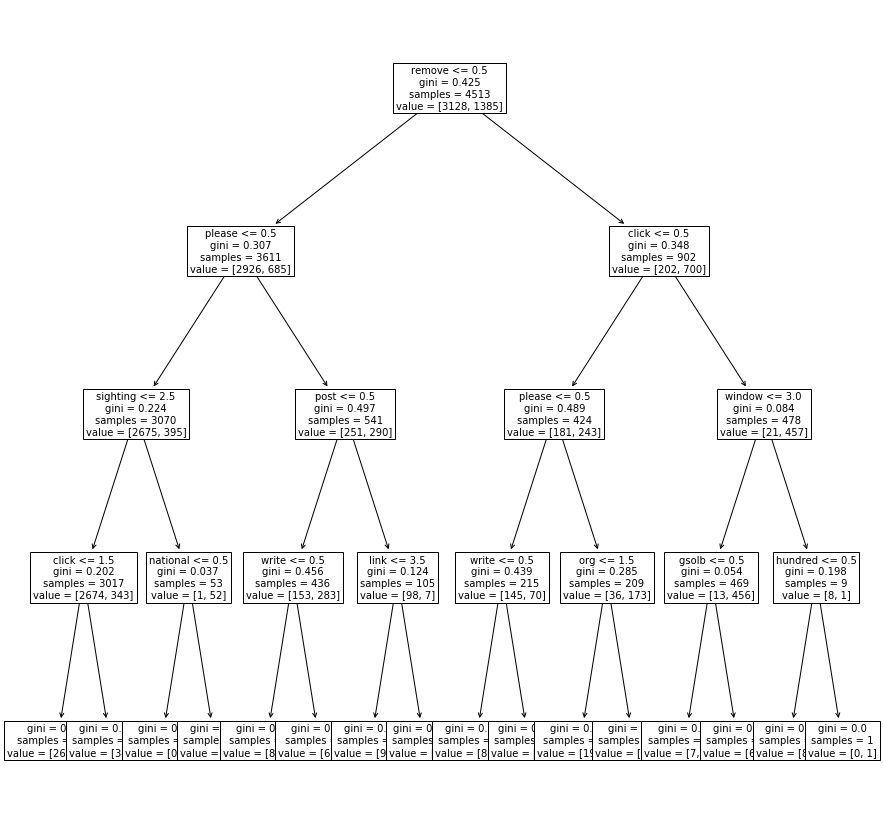

Wall time: 9.05 s


In [24]:
%time predicteur_c.d_tree('gini', 4)

### Arbres de décison sur le contenu avec Entropy

Pourcentage d'emails bien classés : 86%
Nombre d'emails mal classés sur un total de 1505 emails : 208
Nombre de faux positifs : 74
Nombre de faux négatifs : 134


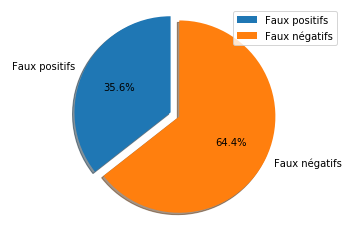

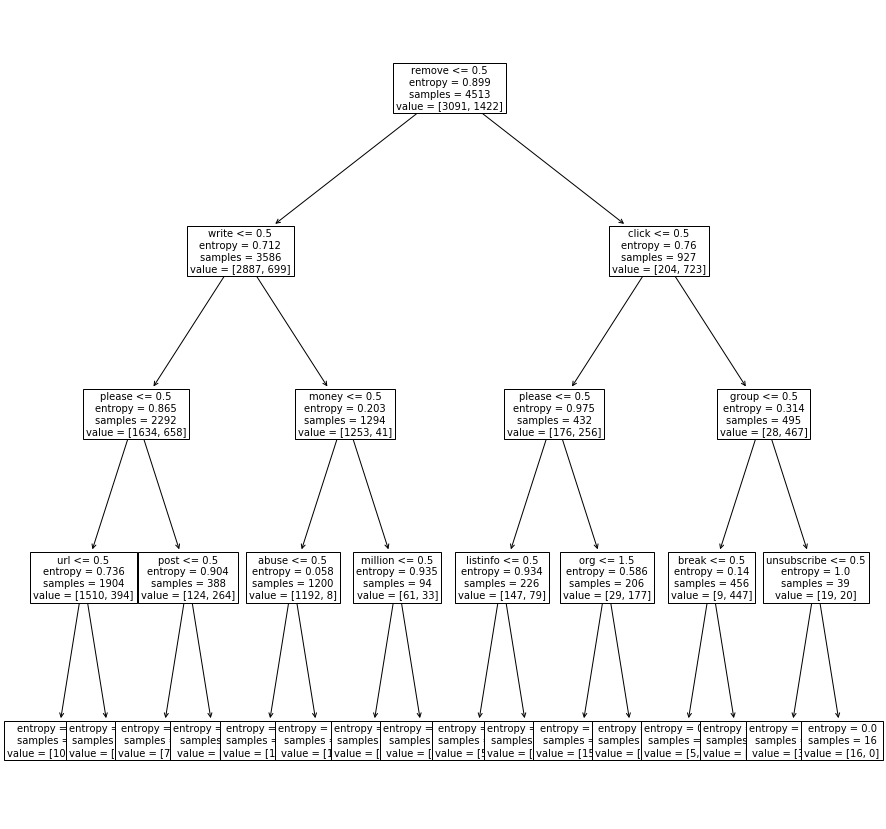

Wall time: 6.97 s


In [25]:
%time predicteur_c.d_tree('entropy', 4)

### Arbres de décison sur l'objet avec Gini

Pourcentage d'emails bien classés : 73%
Nombre d'emails mal classés sur un total de 1505 emails : 399
Nombre de faux positifs : 9
Nombre de faux négatifs : 390


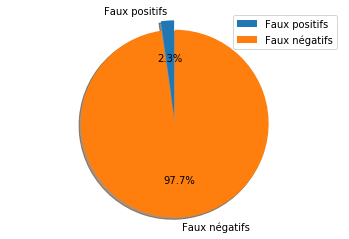

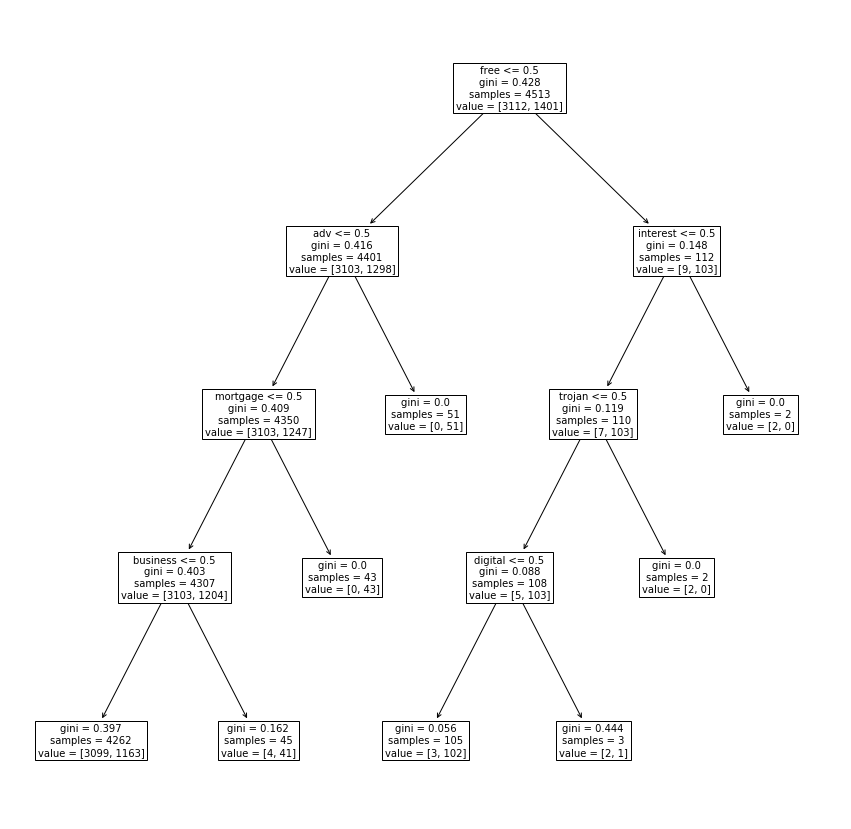

Wall time: 1.17 s


In [26]:
%time predicteur_s.d_tree('gini', 4)

### Arbres de décison sur l'objet avec Entropy

Pourcentage d'emails bien classés : 71%
Nombre d'emails mal classés sur un total de 1505 emails : 429
Nombre de faux positifs : 0
Nombre de faux négatifs : 429


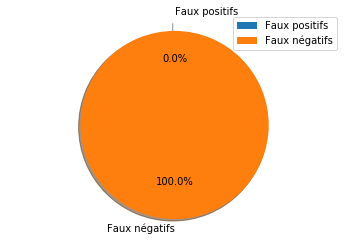

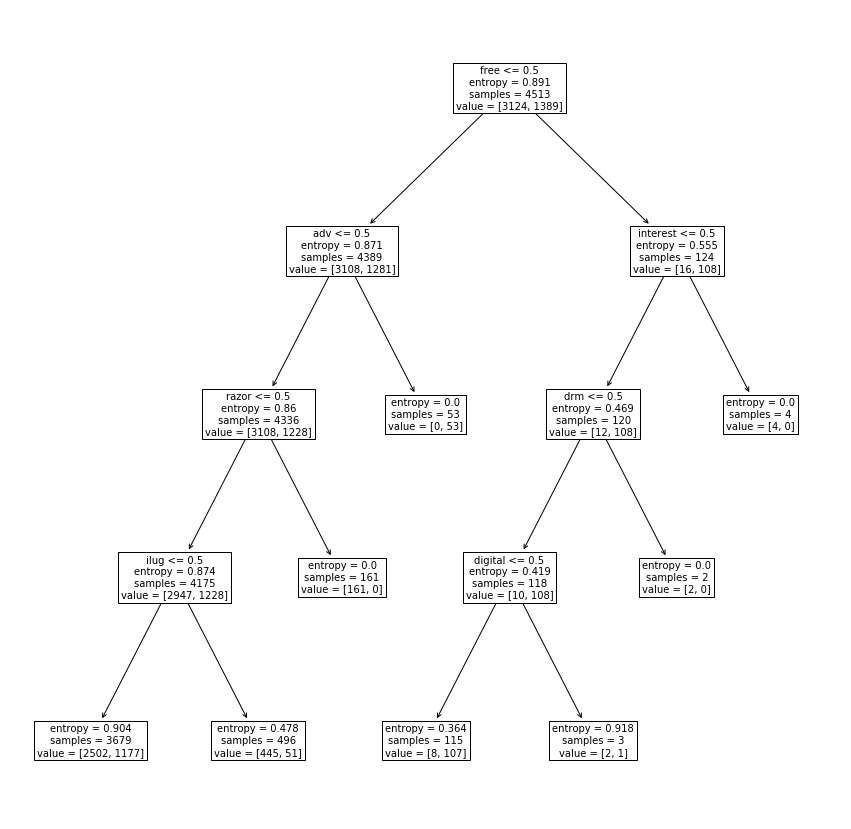

Wall time: 1.05 s


In [27]:
%time predicteur_s.d_tree('entropy', 4)

### Random Forest sur le contenu

Meilleur set de paramètres : {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Pourcentage d'emails bien classés : 85%
Nombre d'emails mal classés sur un total de 1505 emails : 226
Nombre de faux positifs : 2
Nombre de faux négatifs : 224


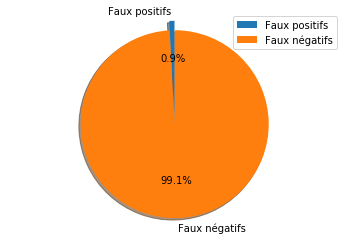

Wall time: 11min 43s


<Figure size 1080x1080 with 0 Axes>

In [28]:
%time predicteur_c.random_forest()

### Random forest sur l'objet

Meilleur set de paramètres : {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Pourcentage d'emails bien classés : 70%
Nombre d'emails mal classés sur un total de 1505 emails : 447
Nombre de faux positifs : 1
Nombre de faux négatifs : 446


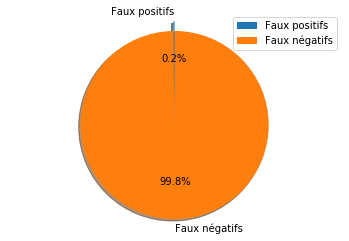

Wall time: 2min 21s


<Figure size 1080x1080 with 0 Axes>

In [29]:
%time predicteur_s.random_forest()

# Récapitulatif des résultats obtenus  <a name="recap"></a>

In [30]:
def show_final_results(data, data2):
    column_labels=["Accuracy", "Faux positif", "Faux négatif"]
    index = list(data.keys())
    df = pd.DataFrame(columns=column_labels)
    for i in range(len(data)):
        df.loc[i] = list(data.values())[i]
    df.index = index
    df.index.name = 'Prédicteur'

    df2 = pd.DataFrame(columns=column_labels)
    index = list(data2.keys())
    for i in range(len(data2)):
        df2.loc[i] = list(data2.values())[i]
    df2.index = index
    df2.index.name = 'Prédicteur'
    df = pd.merge(df, df2, on='Prédicteur', how='outer')
    col_ix = pd.MultiIndex.from_product([['Content', 'Subject'], column_labels])
    df.columns = col_ix
    display(df)

In [31]:
show_final_results(predicteur_c.content, predicteur_s.subject)

Content                             Subject  \
                               Accuracy Faux positif Faux négatif  Accuracy   
Prédicteur                                                                    
Naïve Bayes                    0.944186          9.0         75.0  0.881728   
Régression logistique (TFIDF)  0.965449          7.0         45.0  0.865116   
Régression logistique (BOW)    0.984053         12.0         12.0  0.899003   
svm                            0.940397          3.0          6.0  0.894352   
Arbre de décision (Gini)       0.865116         49.0        154.0  0.714950   
Arbre de décision (Entropy)    0.861794         74.0        134.0  0.734884   
Random Forest                  0.849834          2.0        224.0  0.702990   

                                                         
                              Faux positif Faux négatif  
Prédicteur                                               
Naïve Bayes                          131.0         47.0  
Régression logistique (TFIDF)         14.0        189.0  
Régression logistique (BOW)           45.0        107.0  
svm                                   54.0        105.0  
Arbre de décision (Gini)               0.0        429.0  
Arbre de décision (Entropy)            9.0        390.0  
Random Forest                          1.0        446.0